## Imports necesarios

In [1]:
from concurrent.futures import as_completed
from concurrent.futures.process import ProcessPoolExecutor
from concurrent.futures.thread import ThreadPoolExecutor

import ipyparallel as ipp
import seaborn as sns
import matplotlib.pyplot as plt

import ejercicio7 as ex
from utils import timeit, split_array

sns.set_theme()

## Testers  Bases

### Simple Tester

In [2]:
class Tester:
    def __init__(self, detector: str, matcher: str, image_path: str,
                    dataset_path: str, dataset_size: int, workers: int = 0):
        self.detector, self.matcher = detector, matcher
        self.image_path, self.dataset_path = image_path, dataset_path
        self.dataset_size = dataset_size

        self.to_analyse = ex.load_dataset(self.dataset_path)

### Tester paralelo

In [3]:
class ParallelTester(Tester):
    def __init__(self, detector: str, matcher: str, image_path: str,
                 dataset_path: str, dataset_size: int, workers: int):
        super().__init__(detector, matcher, image_path, dataset_path, dataset_size)

        self.workers = workers
        self.to_analyse = [dict(search=self.image_path, covers=segment, detector=self.detector,
                                matcher=self.matcher, min_matches=ex.MATCHES_THRESHOLD_TO_SHOW)
                           for segment in split_array(self.to_analyse[:self.dataset_size],
                                                      self.dataset_size // self.workers)]

    @staticmethod
    def helper(args):
        import ejercicio7 as ex
        return ex.search_candidates(**args)

## Testers Heredados

### Secuencial

In [4]:
class SequentialTester(Tester):
    name = "SequentialTester"
    @timeit
    def run(self):
        return ex.search_candidates(self.image_path, self.to_analyse[:self.dataset_size],
                                    self.detector, self.matcher, ex.MATCHES_THRESHOLD_TO_SHOW)

### Paralelismo

#### Gestión de hilos ````concurrent.futures.ThreadPoolExecutor````

In [5]:
class ThreadingTester(ParallelTester):
    name = "ThreadingTester"
    @timeit
    def run(self):
        with ThreadPoolExecutor(max_workers=self.workers) as executor:
            futures = [executor.submit(ParallelTester.helper, args) for args in self.to_analyse]
            return [candidate for future in as_completed(futures) for candidate in future.result()]

#### Gestión de subprocesos ````concurrent.futures.ProcessPoolExecutor````

In [6]:
class MultiprocessingTester(ParallelTester):
    name = "MultiprocessingTester"
    @timeit
    def run(self):
        with ProcessPoolExecutor(max_workers=self.workers) as executor:
            results = executor.map(ParallelTester.helper, self.to_analyse)
            return [candidate for result in results for candidate in result]

#### Gestión de clústers ``IPyparallel``

In [7]:
class IPyParallelTester(ParallelTester):
    name = "IPyParallelTester"
    @timeit
    def run(self):
        direct_view = ipp.Client()[:]  # use all engines
        result = direct_view.map(ParallelTester.helper, self.to_analyse)
        return [candidate for result in result.get() for candidate in result]

## Factory

In [8]:
def tester_factory(name): 
    testers = { "SequentialTester": SequentialTester,
                "ThreadingTester": ThreadingTester,
                "MultiprocessingTester": MultiprocessingTester,
                "IPyParallelTester": IPyParallelTester}
    return testers[name]

## Parámetros

In [9]:
im_path = "book-covers/Art-Photography/0000001.jpg"
dataset_path = "book-covers"

dataset_size = [10, 50, 100, 500, 1000, 5000, 10000, 30000]

# Tests

In [14]:
def test(tester_name, dataset_sizes: list, workers: list):
    tests = {}
    
    for w in workers:
        test_data = []
        for size in dataset_sizes:
            args = dict(detector=ex.DEFAULT_DETECTOR, matcher=ex.DEFAULT_MATCHER,
                        image_path=im_path, dataset_path=dataset_path, 
                        dataset_size=size, workers=w)
            tester = tester_factory(tester_name)(**args)
            _, time = tester.run()
            test_data.append(time)
            tests[w] = test_data
    
    return tests


def plot(tests, tester_name, dataset_sizes):
    fig, ax = plt.subplots(figsize=(16, 8))
    for k, v in tests.items():
        ax.plot(v, "o-", label=f"{k} worker" if k==1 else f"{k} workers")
    
    ax.set_ylabel('Times (secs)')
    ax.set_xlabel('Amount of batch')
    ax.set_title(tester_name)
    ax.set_xticks(range(len(dataset_sizes)))
    ax.set_xticklabels(dataset_sizes)
    ax.legend()
    
    plt.show()

## Sequential time

In [11]:
seq_time = test("SequentialTester", dataset_size, [1])

P: 13448, TH: MainThread: 100%|██████████| 10000/10000 [01:06<00:00, 150.67it/s]


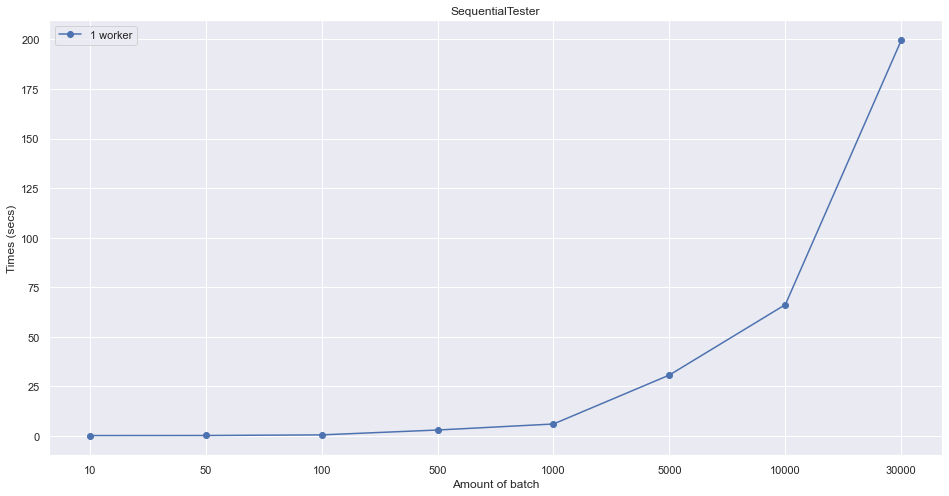

In [16]:
plot(seq_time, "SequentialTester", dataset_size)

## Threading Time

In [17]:
th_workers = [2, 4, 10, 20, 40]
th_time = test("ThreadingTester", dataset_size, th_workers)

P: 13448, TH: ThreadPoolExecutor-18_9: 100%|██████████| 10/10 [00:00<00:00, 64.52it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















P: 13448, TH: ThreadPoolExecutor-19_5: 100%|██████████| 50/50 [00:00<00:00, 85.32it/s]


P: 13448, TH: ThreadPoolExecutor-19_9: 100%|██████████| 50/50 [00:00<00:00, 86.36it/s]









P: 13448, TH: ThreadPoolExecutor-20_8:   0%|          | 0/100 [00:00<?, ?it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:   9%|▉         | 9/100 [00:00<00:01, 84.11it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  21%|██        | 21/100 [00:00<00:00, 91.35it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  33%|███▎      | 33/100 [00:00<00:00, 95.80it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  44%|████▍     | 44/100 [00:00<00:00, 97.80it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  54%|█████▍    | 54/100 [00:00<00:00, 96.46it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  64%|██████▍   | 64/100 [00:00<00:00, 96.09it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  73%|███████▎  | 73/100 [00:00<00:00, 93.88it/s]








P: 13448, TH: ThreadPoolExecutor-20_8:  82%|████████▏ | 82/100 [00:00<00:00, 86.78it/s]








P: 13448, TH: ThreadPoolExecutor-23_9: 100%|██████

P: 13448, TH: ThreadPoolExecutor-25_19: 100%|██████████| 2/2 [00:00<00:00, 20.62it/s]

P: 13448, TH: ThreadPoolExecutor-30_11: 100%|██████████| 500/500 [00:24<00:00, 20.67it/s]


P: 13448, TH: ThreadPoolExecutor-33_28: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

P: 13448, TH: ThreadPoolExecutor-34_3:   0%|          | 0/2 [00:00<?, ?it/s]








P: 13448, TH: ThreadPoolExecutor-34_3: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


P: 13448, TH: ThreadPoolExecutor-35_4: 100%|██████████| 12/12 [00:00<00:00, 36.25it/s]









P: 13448, TH: ThreadPoolExecutor-36_27:   0%|          | 0/25 [00:00<?, ?it/s]








P: 13448, TH: ThreadPoolExecutor-36_27:  16%|█▌        | 4/25 [00:00<00:00, 39.60it/s]








P: 13448, TH: ThreadPoolExecutor-36_27:  32%|███▏      | 8/25 [00:00<00:00, 38.68it/s]








P: 13448, TH: ThreadPoolExecutor-36_27:  44%|████▍     | 11/25 [00:00<00:00, 34.37it/s]










P: 13448, TH: ThreadPoolExecutor-36_27:  56%|█████▌    | 14/25 [00:00<00:00, 31.98it/s]








P: 13448, TH: ThreadPoolExecutor-36_27:  72%|███████▏  | 18/25 [00:00<00:00, 33.43it/s]








P: 13448, TH: ThreadPoolExecutor-36_37: 100%|██████████| 25/25 [00:00<00:00, 46.73it/s]




P: 13448, TH: ThreadPoolExecutor-37_3:   0%|          | 0/125 [00:00<?, ?it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:   4%|▍         | 5/125 [00:00<00:03, 39.68it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:   7%|▋         | 9/125 [00:00<00:03, 38.18it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:   9%|▉         | 11/125 [00:00<00:03, 29.19it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:   0%|          | 0/125 [00:00<?, ?it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  11%|█         | 14/125 [00:00<00:03, 28.05it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:   4%|▍         | 5/125 [00:00<00:02, 48.73it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  14%|█▎        | 17/125 [00:00<00:04,

P: 13448, TH: ThreadPoolExecutor-37_28:  28%|██▊       | 35/125 [00:01<00:05, 16.13it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  38%|███▊      | 48/125 [00:02<00:04, 16.55it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:  30%|██▉       | 37/125 [00:02<00:05, 16.45it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  40%|████      | 50/125 [00:02<00:04, 15.95it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:  31%|███       | 39/125 [00:02<00:05, 16.15it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  42%|████▏     | 52/125 [00:02<00:04, 15.93it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:  33%|███▎      | 41/125 [00:02<00:05, 16.07it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  43%|████▎     | 54/125 [00:02<00:04, 16.26it/s]














P: 13448, TH: ThreadPoolExecutor-37_28:  34%|███▍      | 43/125 [00:02<00:05, 16.09it/s]



P: 13448, TH: ThreadPoolExecutor-37_3:  45%|████▍     | 56/125 [00:03<00:04, 15.25it/s]














P: 13448, TH: ThreadPoolExecut

P: 13448, TH: ThreadPoolExecutor-37_39: 100%|██████████| 125/125 [00:04<00:00, 26.30it/s]


















P: 13448, TH: ThreadPoolExecutor-38_31:   0%|          | 0/250 [00:00<?, ?it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   2%|▏         | 4/250 [00:00<00:06, 36.04it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   2%|▏         | 6/250 [00:00<00:09, 25.40it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   4%|▎         | 9/250 [00:00<00:09, 25.34it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   4%|▍         | 11/250 [00:00<00:10, 22.51it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   5%|▌         | 13/250 [00:00<00:11, 21.08it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   6%|▌         | 15/250 [00:00<00:12, 19.13it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   7%|▋         | 17/250 [00:00<00:12, 18.22it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:   8%|▊         |

P: 13448, TH: ThreadPoolExecutor-38_31:  32%|███▏      | 79/250 [00:05<00:15, 10.87it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  32%|███▏      | 81/250 [00:06<00:16, 10.38it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  33%|███▎      | 83/250 [00:06<00:16, 10.11it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  34%|███▍      | 85/250 [00:06<00:16,  9.82it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  34%|███▍      | 86/250 [00:06<00:19,  8.32it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  35%|███▍      | 87/250 [00:06<00:21,  7.48it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  35%|███▌      | 88/250 [00:07<00:23,  6.93it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  36%|███▌      | 89/250 [00:07<00:25,  6.42it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  36%|███▌      | 90/250 [00:07<00:26,  6.10it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  36%|█

P: 13448, TH: ThreadPoolExecutor-38_31:  53%|█████▎    | 133/250 [00:15<00:21,  5.49it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  54%|█████▎    | 134/250 [00:15<00:20,  5.67it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  54%|█████▍    | 135/250 [00:15<00:20,  5.71it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  54%|█████▍    | 136/250 [00:15<00:19,  5.71it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  55%|█████▍    | 137/250 [00:15<00:19,  5.66it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  55%|█████▌    | 138/250 [00:15<00:18,  5.92it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  56%|█████▌    | 139/250 [00:16<00:18,  6.08it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  56%|█████▌    | 140/250 [00:16<00:18,  6.05it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  56%|█████▋    | 141/250 [00:16<00:18,  6.01it/s]

















P: 13448, TH: ThreadPoolExecutor-38_3

P: 13448, TH: ThreadPoolExecutor-38_31:  74%|███████▎  | 184/250 [00:22<00:09,  6.99it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  74%|███████▍  | 185/250 [00:22<00:09,  6.86it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  74%|███████▍  | 186/250 [00:23<00:09,  6.68it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  75%|███████▍  | 187/250 [00:23<00:09,  6.77it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  75%|███████▌  | 188/250 [00:23<00:09,  6.74it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  76%|███████▌  | 190/250 [00:23<00:07,  7.85it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  77%|███████▋  | 192/250 [00:23<00:06,  9.41it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  78%|███████▊  | 194/250 [00:23<00:05, 10.48it/s]

















P: 13448, TH: ThreadPoolExecutor-38_31:  78%|███████▊  | 196/250 [00:23<00:04, 11.26it/s]

















P: 13448, TH: ThreadPoolExecutor-38_3

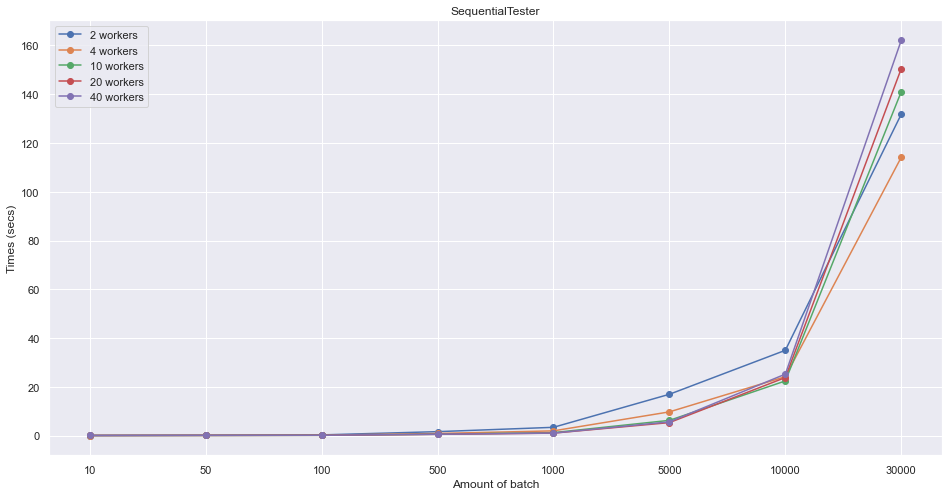

In [18]:
plot(th_time, "ThreadingTester", dataset_size)

## IPyparallel Time

In [26]:
!ipcluster start -n 40

2020-12-21 15:42:33.468 [IPClusterStart] CRITICAL | Cluster is already running with [pid=14324]. use "ipcluster stop" to stop the cluster.


In [24]:
!ipcluster stop

2020-12-21 15:39:19.771 [IPClusterStart] Removing pid file: C:\Users\europ\.ipython\profile_default\pid\ipcluster.pid
2020-12-21 15:39:19.771 [IPClusterStart] Starting ipcluster with [daemon=False]
2020-12-21 15:39:19.771 [IPClusterStart] Creating pid file: C:\Users\europ\.ipython\profile_default\pid\ipcluster.pid
2020-12-21 15:39:19.771 [IPClusterStart] Starting Controller with LocalControllerLauncher
2020-12-21 15:39:20.787 [IPClusterStart] Starting 4 Engines with LocalEngineSetLauncher
2020-12-21 15:39:51.100 [IPClusterStart] Engines appear to have started successfully
2020-12-21 15:40:57.222 [IPClusterStop] Removing pid file: C:\Users\europ\.ipython\profile_default\pid\ipcluster.pid


In [27]:
cl_workers = [2, 4, 10, 20, 40]
cl_time = test("IPyParallelTester", dataset_size, cl_workers)

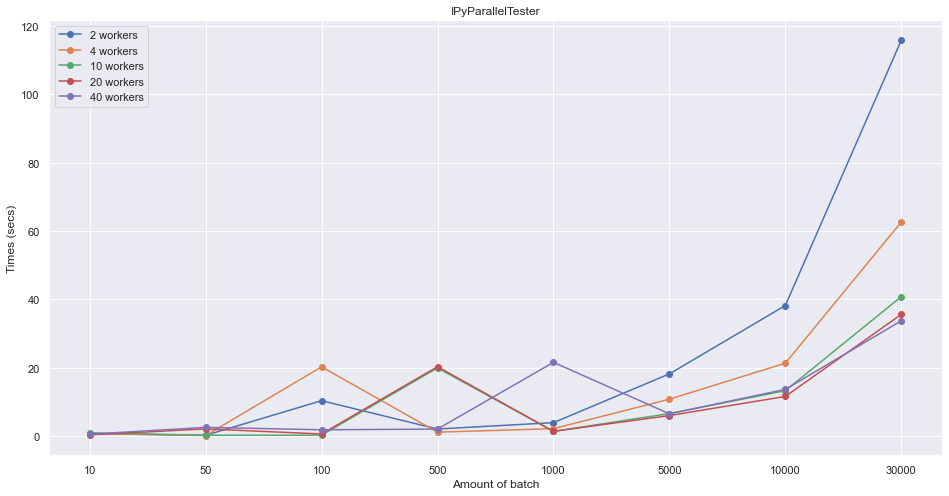

In [28]:
plot(cl_time, "IPyParallelTester", dataset_size)